In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
input_size = 784

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
params = {
    'e_layers': [128],
    'd_layers': [128],
    'd_std': 0.3,
    'z_dim': 10,
    'activation': 'sigmoid',
    'batch_size': 100,
    'epochs': 10,
    'learning_rate': 0.0005
}

In [4]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation={'tanh': tf.nn.tanh, 'sigmoid': tf.nn.sigmoid}[params['activation']])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation={'tanh': tf.nn.tanh, 'sigmoid': tf.nn.sigmoid}[params['activation']])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)

In [5]:
images = tf.placeholder(tf.float32, (None, input_size), name='image')
e_mu, e_var = encoder(images, params['e_layers'])
eps = tf.random_normal([tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = e_mu + tf.sqrt(e_var) * eps
d_mu = decoder(z, params['d_layers'])

In [6]:
# Calculate losses
loss_encode = - 0.5 * tf.reduce_sum(1 + tf.log(e_var) - e_mu ** 2 - e_var, axis=1)
loss_decode = - tf.reduce_sum(tf.contrib.distributions.Normal(d_mu, params['d_std']).log_prob(images), axis=1)
loss = tf.reduce_mean(loss_encode + loss_decode, axis=0)

In [7]:
# Optimizers
train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [8]:
samples = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(params['epochs']):
        for ii in range(mnist.train.num_examples / params['batch_size']):
            batch = mnist.train.next_batch(params['batch_size'])
            
            # Get images
            batch_images = batch[0].reshape((params['batch_size'], input_size))
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(params['batch_size'], params['z_dim']))
            
            # Run optimizer
            sess.run(train_op, feed_dict={images: batch_images})
        
        # At the end of each epoch, get the loss and print it out
        train_loss = sess.run(loss, {images: batch_images})
            
        print("Epoch {}/{}...".format(e+1, params['epochs']),
              "Loss: {:.4f}".format(train_loss))
        # Save losses to view after training
        losses.append(train_loss)
        
        # Sample an image as we're training for viewing afterwards
        sample_z = np.random.randn(16, params['z_dim'])
        gen_samples = sess.run(
                       d_mu,
                       feed_dict={z: sample_z})
        samples.append(gen_samples)
        if np.isnan(train_loss):
            print 'loss is NaN!'
            break

('Epoch 1/10...', 'Loss: 27.6270')
('Epoch 2/10...', 'Loss: -23.5441')
('Epoch 3/10...', 'Loss: -38.2285')
('Epoch 4/10...', 'Loss: -46.2515')
('Epoch 5/10...', 'Loss: -63.8773')
('Epoch 6/10...', 'Loss: -72.7560')
('Epoch 7/10...', 'Loss: -65.1852')
('Epoch 8/10...', 'Loss: -79.4860')
('Epoch 9/10...', 'Loss: -84.5037')
('Epoch 10/10...', 'Loss: -81.7268')


/Users/yoel.z/projects/kaggle/kaggle-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


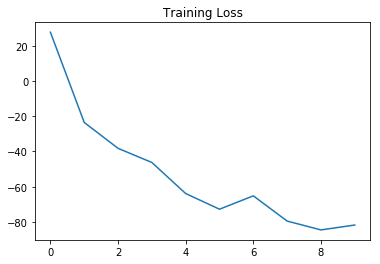

In [9]:
fig, ax = plt.subplots()
plt.plot(losses)
plt.title('Training Loss')
plt.legend()

In [10]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

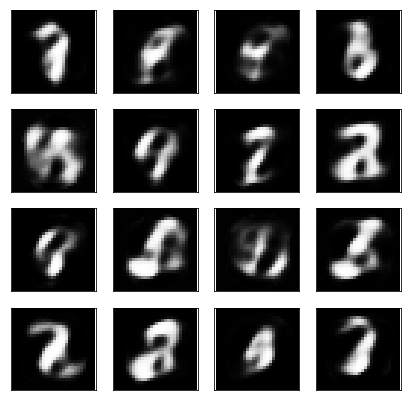

In [11]:
view_samples(-1, samples)

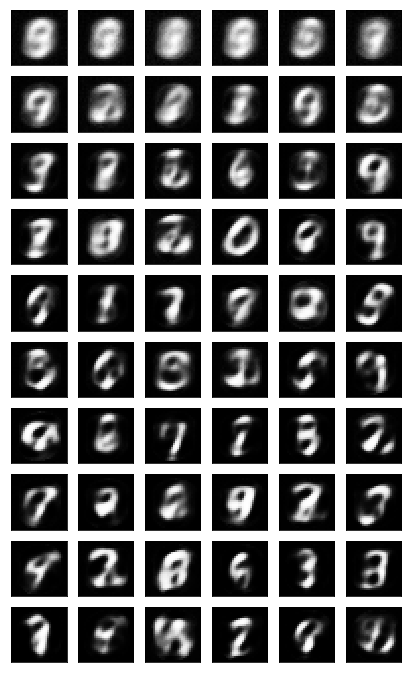

In [12]:
rows, cols = min(len(samples), 20), 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)